# CS188 Assignment 2

Before we start, please put your name and UD in following format

: Firstname LASTNAME, #00000000   //   e.g.) Yining Hong, #123456789

**Your Answer:**   
Your NAME, #XXXXXXXX

In this assignment, we will go through the whole training procedure using pytorch. Please refer to the tutorials for Discussion Week 2. 
We will use pytorch to train MLP and CNN networks.

# Setup Code

First, download the miniplaces images folder (which we did for last assignment). Zip it, upload it to the assignment folder, and unzip it below.
(The unzipping process will take about 15 minutes.)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 188 folder and put all the files under Assignment1 folder, then '188/Assignment1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '188/Assignment2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '188/Assignment2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

Only run this once! The unzipping process will take about 15~20 minutes.
The file transfer to Google Drive may take a while but you can still run this notebook using cache. (weird drive data storage)
However, if you close the browser, you may have to unzip it again.
You may need to keep the notebook open for 3~4 hours to completely upload the data to google drive.
Use the information button on the right of google drive to see if the data of one folder has completely uploaded.

In [ ]:
import zipfile
from google.colab import drive

# zip_ref = zipfile.ZipFile(os.path.join(GOOGLE_DRIVE_PATH, "images.zip"), 'r')
# zip_ref.extractall(os.path.join(GOOGLE_DRIVE_PATH))
# zip_ref.close()
!tar -xvf "/content/drive/My Drive/188/Assignment2/images.tar" -C "/content/drive/My Drive/188/Assignment2/" #for tar
!unzip "/content/drive/My Drive/188/Assignment2/images.zip" -d "/content/drive/My Drive/188/Assignment2/" #for zip

# Data Loader (25 pts)

You will implement a pytorch data loader for MiniPlaces. The tutorial is: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/57a471142057f27da635118e88a99bf6/data_tutorial.ipynb

Follow the instructions in dataset.py and fill in the codes.

In [ ]:
import dataset
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
training_data = dataset.MiniPlaces(
    split = 'train',
    root_dir = GOOGLE_DRIVE_PATH
)
print (len(training_data))

validation_data = dataset.MiniPlaces(
    split='val',
    root_dir = GOOGLE_DRIVE_PATH
)

Visualize the image in each category.

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(24, 24))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label, label_text = training_data[sample_idx]
    print (img.size()) # should be [64, 64, 3]
    figure.add_subplot(rows, cols, i)
    plt.title(label_text)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
import model
import optimizer
import torch
import random
from train import train_one_epoch
from torch import nn
from tqdm import tqdm


training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=2)

# Multi-Layer Perceptron (30 pts)
We will implement MLP from scratch step by step in the following section.

## MLP Using Pytorch Built-in Modules

You will build first build MLP using build-in nn.linear and F.relu function. Please fill in the FastMLP class in model.py

We will also use built-in cross-entropy loss and optimizer to train the model.
Each epoch takes approximately 3 minutes.

Please refer to https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/611efa3e10bb2b546f3a33742edc4ecc/modelsyt_tutorial.ipynb
for model writing.

In [ ]:
from model import FastMLP
random.seed(0)
torch.random.manual_seed(0)
model = FastMLP(1024, 12288, 100).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, training_loader, optimizer, model, loss_fn)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.reshape(vinputs.shape[0], -1)
        voutputs = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


I can get 10% accuracy for the first epoch. What about you?
(The accuracy depends much on random seed so it's fine to get lower accuracy.)

## MLP from scratch
Next, you will implement your own MLP without pytorch built-in modules.
Copy your linear function of the last assignment to the linear function in model.py
Implement ReLU function.
Then Implement the whole MLP class.

In [ ]:
from model import MLP
random.seed(0)
torch.random.manual_seed(0)
model = MLP(1024, 12288, 100).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, training_loader, optimizer, model, loss_fn)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.reshape(vinputs.shape[0], -1)
        voutputs = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


If your implementation is right. You should get similar results as before.

### Cross Entropy Loss
The next thing is to write your own cross entropy loss.
It's really simple.
Just copy your implementation of softmax function and nllloss in the last assignment.
cross entropy loss is a combination of both.

Implement softmax function, nllloss function and cross entropy loss class in model.py

In [ ]:
from model import MLP, CrossEntropyLoss
random.seed(0)
torch.random.manual_seed(0)
model = MLP(1024, 12288, 100).cuda()
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, training_loader, optimizer, model, loss_fn)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.reshape(vinputs.shape[0], -1)
        voutputs = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


If your implementation is right, you'll get similar results as before.

### SGD
Next, you will implement the SGD optimizer from scratch.
The algorithm is listed in the image below. Note that here we set weight decay , damping and nesterov to be zero.

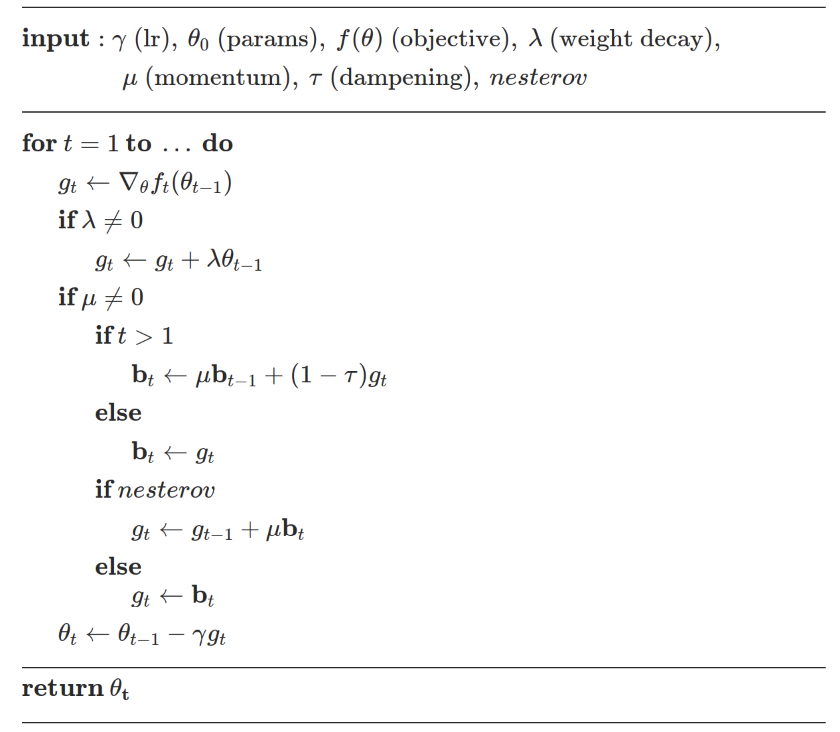

In [ ]:
from model import MLP, CrossEntropyLoss
from optimizer import SGD
random.seed(0)
torch.random.manual_seed(0)
model = MLP(1024, 12288, 100).cuda()
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=2)

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, training_loader, optimizer, model, loss_fn)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.reshape(vinputs.shape[0], -1)
        voutputs = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

If your implementation is right, you should get similar results as before.

### Adam 
Now, we switch to Adam optimizer. We first use pytorch built-in Adam.

In [ ]:
from model import MLP, CrossEntropyLoss
random.seed(0)
torch.random.manual_seed(0)
model = MLP(1024, 12288, 100).cuda()
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=2)

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, training_loader, optimizer, model, loss_fn)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.reshape(vinputs.shape[0], -1)
        voutputs = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

I can get 0.07 accuracy, how about you?

Now, you need to implement your own Adam optimizer in optimizer.py. The algorithm is as below: (we have weight dacay, amsgrad as zeroes)
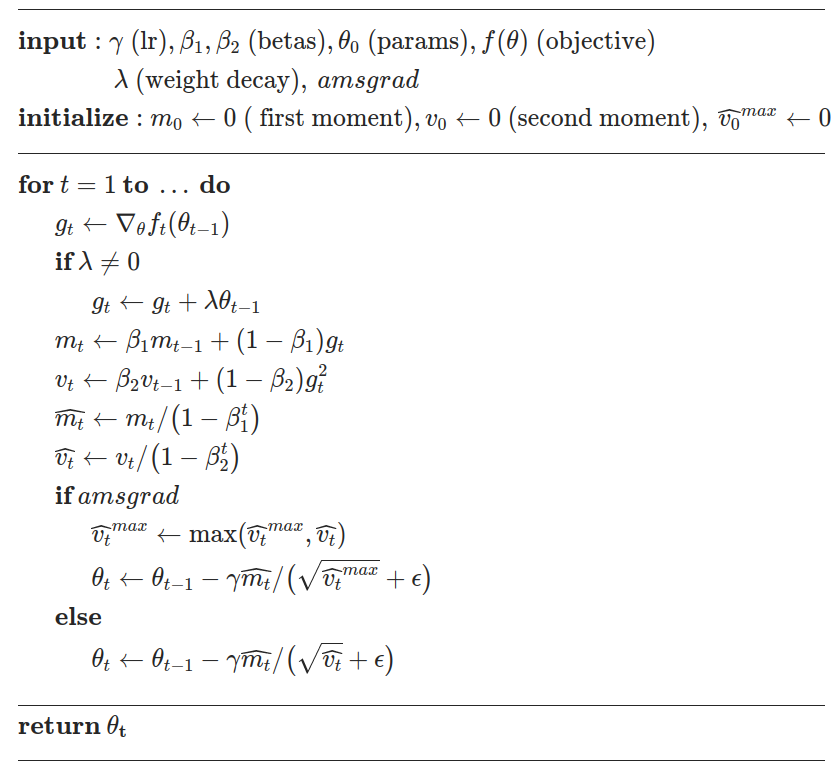

In [ ]:
from model import MLP, CrossEntropyLoss
from optimizer import Adam
random.seed(0)
torch.random.manual_seed(0)
model = MLP(1024, 12288, 100).cuda()
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=2)

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, training_loader, optimizer, model, loss_fn)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.reshape(vinputs.shape[0], -1)
        voutputs = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

If your implementation is right, you should get similar results as before.


## Convolutional Neural Networks (CNN) (20 pts)

In this section, we will build a two-layer convolutional neural networks. First, we will use pytorch built-in function nn.Conv2d. Please implement the class: FastConv in model.py

In [ ]:
import model
from model import FastConv
random.seed(0)
torch.random.manual_seed(0)
model = FastConv().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=1)

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    len_samples = 0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(tqdm((training_loader))):
        # Every data instance is an input + label pair
        inputs, labels, _ = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        inputs = inputs.permute(0,3,1,2)
        len_samples += inputs.shape[0]
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs, _, _ = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
 
    last_loss = running_loss / len_samples
    print('  batch {} loss: {}'.format(i + 1, last_loss))

    return last_loss

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    total_vacc = 0.
    len_samples = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels, _ = vdata
        vinputs = vinputs.cuda()
        vlabels = vlabels.cuda()
        len_samples += vinputs.shape[0]
        vinputs = vinputs.permute(0,3,1,2)
        voutputs, _, _ = model(vinputs)
        
        vloss = loss_fn(voutputs, vlabels)
        
        voutputs = torch.argmax(voutputs, -1)
        acc = torch.sum(torch.eq(voutputs, vlabels))
        total_vacc += acc.item()
        
        running_vloss += vloss.item()
        
    print ('validation acc is: %f'%(total_vacc/len_samples))
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


I can obtain 14% accuracy for the 1st epoch. How about you?

### Question: Please calculate the output dimension and size of each pytorch function in the FastConv forward function. Write down your calculation below.
[Your answer]: 

### Visualize weights
We will visualize the weights of each layer

In [ ]:
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(16, 16))

for i, filter in enumerate(model_weights[0].cpu()):
    plt.subplot(4, 8, i+1) 
    plt.imshow(filter[0, :, :].detach(), cmap='gray')

plt.show()

We see that there are 32 images (because there are 32 kernels / filters). Each filter is of 3*3 size.

You may notice that some patches are dark and others are bright. We know that pixel values range from 0 to 255. 0 corresponds fully black color, and 255 corresponds to the white color. This means that the dark patches have a lower weight than the brighter patches.

When the affine transformations take place with the input image, then the white patches will be more responsible for the activation of that part of the image. In simple words, the model will focus more on the area of the image where the weight values are more when doing the element-wise product of the weights with the pixel values.

### Visualize the feature maps

The following image will show the feature map from the first convolutional layer (layer 0).

In [ ]:
vdata = validation_data[0]
vinputs, vlabels, _ = vdata
vinputs = vinputs.cuda()
vlabels = vlabels
len_samples += vinputs.shape[0]
vinputs = vinputs.permute(2,0,1).unsqueeze(0)
voutputs, output1, output2 = model(vinputs)
output1 = output1.squeeze().cpu()
output2 = output2.squeeze().cpu()

plt.figure(figsize=(30, 30))
layer_viz = output1
layer_viz = layer_viz.data

for i, filter in enumerate(layer_viz):
    if i == 64: # we will visualize only 8x8 blocks from each layer
        break
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter, cmap='gray')
    plt.axis("off")

plt.show()
plt.close()

you can see that different filters focus on different aspects while creating the feature map of an image.

Some feature maps focus on the background of the image. Some others create an outline of the image. A few filters create feature maps where the background is dark but the image of the cat is bright. This is due to the corresponding weights of the filters. It is very clear from the above image that in the deep layers, the neural network gets to see very detailed feature maps of the input image. 



## Convolutional from scratch. 
Next, we will build convolutional neural networks from scratch. Please refer to https://github.com/d2l-ai/d2l-en/tree/master/chapter_convolutional-neural-networks for more instructions.

That's start with cross-correlation with only 1 input channel and 1 kernel. Please implement corr2d in model.py.
If your implementation is right, you'll get:
tensor([[19., 25.],
        [37., 43.]])

In [ ]:
from model import corr2d
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

The next thing is to add stride to the corr2d function. Please implement corr2d_stride. If your implementation is right, the correct output is tensor([[19., 31.], [50., 62.]])

In [ ]:
import model
from model import corr2d_stride
X = torch.tensor([[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0], [6.0, 7.0, 8.0, 9.0], [8.0, 9.0, 10.0, 11.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d_stride(X, K, stride=2)

Then, we'll consider the cases where there are multiple input channels. The correct output is 56.

In [ ]:
from model import corr2d_multi_in

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K, stride=2)

Now we consider the case where there are multiple kernels/filters/output channels. Please implement corr2d_multi_in_out. The correct output is:

torch.Size([2, 2, 2])
torch.Size([2, 3, 3]) torch.Size([3, 2, 2, 2]) torch.Size([3, 1, 1])
tensor([[[56.]],
        [[76.]],
        [[96.]]], device='cuda:0')

In [ ]:
from model import corr2d_multi_in_out
print (K.size())
K = torch.stack((K, K + 1, K + 2), 0)

output = corr2d_multi_in_out(X, K, stride=2)
print (X.size(), K.size(), output.size())
print (output)

Since the for loops take a lot of time to train, we will not implement the whole Convolutional networks from scratch.

# Write your own Model (25 pts)

You will try to build your own model with built-in convolutional layers. You can base your model on FastConv, modify number of convolutional layers / feature size / learning rate / optimizer and so on. You can put this model class under model.py

You will choose the best model on the validation set, and then test on the test set.
You should generate a file "test_UID.txt", which has the same format as "val.txt". You should put this file in your assignment folder. Test.txt like this:
00000001.jpg 37
00000002.jpg 44
...
00009999.jpg 12
00010000.jpg 4

We will hold a leaderboard on the accuracies on the test set after the deadline. Top 20% students can receive a bonus of 5 points.

In [ ]:
# Your training code here.

test_data = dataset.MiniPlaces(
    split='test',
    root_dir = GOOGLE_DRIVE_PATH
)

.................

### What methods or techniques did you try to improve the performance of your model? What is the final model like?

[Your Answer]